In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,BaseMessage,AIMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from typing import List,Annotated,TypedDict,Literal
from pydantic import BaseModel,Field
from dotenv import load_dotenv

In [ ]:
load_dotenv()

True

In [ ]:
model=ChatGroq(model="llama-3.1-8b-instant")

In [ ]:
class StateSchema(TypedDict):
    # user request:
    natural_language:str

    # latest output:
    sql_query:list[BaseMessage,add_messages]
    confidence_score:float
    feedback:list[BaseMessage,add_messages]

    # loop control:
    iteration:int

In [ ]:
class SQLSchema(BaseModel):
    sql_query:Annotated[str,Field(...,description="The transalted SQL command to query from the database")]
    confidence_score:Annotated[float,Field(...,description="The confidence score of how confident you are that the SQL command will work in scale of 0-1",ge=0,le=1)]
    feedback:Annotated[str,Field(...,description="Concerns, assumptions, ambiguities, or validation notes. If fully confident, say so.")]

In [ ]:
model1=model.with_structured_output(SQLSchema)

In [ ]:
def translator(state:StateSchema):
    sys_instr=SystemMessage(content="You are an SQL expert. Given a natural language you are able to convert it into a robust SQL query to extract the required stuffs from the database fields sql_query,confidence_score and feedback/concern if you are not hundred percent sure else I am confident")
    human_msg=HumanMessage(content=f"Natural Language:{state['natural_language']}")

    response=model1.invoke([sys_instr,human_msg])

    return {
        'sql_query':response.sql_query,
        'confidence_score':response.confidence_score,
        'feedback':response.feedback
    }

def optimize(state:StateSchema):
    last_query=state["sql_query"][-1]
    last_feedback=state["feedback"][-1]
    sys_instr=SystemMessage(content="You are an SQL expert. Given a natural language, SQL query which needs refinement based on feeback, can you give output in field refined SQL query and confidence score on how confident you are")
    human_msg=HumanMessage(content=f"Natural Language:{state['natural_language']},SQL Query:{last_query},Feebdack:{last_feedback}")

    response=model1.invoke([sys_instr,human_msg])

    return {
        'sql_query':response.sql_query,
        'confidence_score':response.confidence_score,
        'feedback':response.feedback
    }

def condition_check(state:StateSchema):
    if state["confidence_score"]>0.8:
        return "approved"
    return "rejected"



In [ ]:
graph=StateGraph(StateSchema)

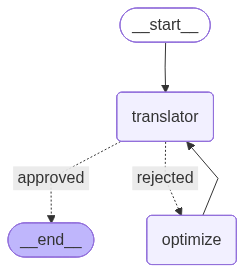

In [ ]:
graph.add_node('translator',translator)
graph.add_node('optimize',optimize)

graph.add_edge(START,'translator')
graph.add_conditional_edges('translator',condition_check,{'approved':END,'rejected':'optimize'})
graph.add_edge('optimize','translator')

workflow=graph.compile()
workflow

In [ ]:
initial_state={
    'natural_language':'From a database with students,subjects,marks. Can you write a SQL query to get the name and highest marks of the student'
}
workflow.invoke(initial_state)

{'natural_language': 'From a database with students,subjects,marks. Can you write a SQL query to get the name and highest marks of the student',
 'sql_query': 'SELECT name, MAX(marks) FROM students, subjects, marks WHERE students.student_id = marks.student_id AND subjects.subject_id = marks.subject_id GROUP BY name',
 'confidence_score': 1.0,
 'feedback': 'The query fetches the name and maximum marks of each student by joining the students, subjects and marks tables based on their IDs and grouping the result by student name.'}